# Introduction
This is part 2 for this competitions submit  
U-net base on ResNet34 transfer learning  
This kernel use Unet Base on ResNet34 model  
For pre data process and data augumatation reference by Kevin's kernel  
Use bce_log+dice_loss for ResNet34+Unet loss function  
ResNet34+ Unet model reference by this GITHUB  
Part1 - Simple tansfer learning to detect ship exist  
https://www.kaggle.com/super13579/simple-transfer-learning-detect-ship-exist-keras  
Part3 - Submittion result with predict ship + Unet34 (0.628)  
https://www.kaggle.com/super13579/unet34-predict-result  


https://www.kaggle.com/super13579/u-net-base-on-resnet34-transfer-learning-keras

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
#from skimage.util.montage import montage2d as montage
path = "/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship Detection Challenge/"


import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


train = pd.read_csv(os.path.join(path + 'train_ship_segmentations_v2.csv'))

print(train.shape[0],'masks found')

train.head()

231723 masks found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


# Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [2]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = path 
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [4]:
masks = pd.read_csv(os.path.join(path,
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


# Split into training and validation groups

We stratify by the number of boats appearing so we have nice balances in each set



,ImageId,ships,has_ship,has_ship_vec,file_size_kb
104934,8b912b47d.jpg,0,0.0,[0.0],103.580078
110164,9271eb839.jpg,0,0.0,[0.0],110.807617
89494,76d311f7f.jpg,1,1.0,[1.0],122.270508
69041,5bd3b8058.jpg,0,0.0,[0.0],113.281250
95955,7f9ae4d3d.jpg,0,0.0,[0.0],219.289062


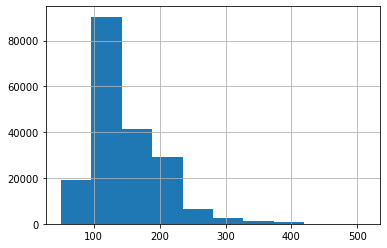

In [5]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [6]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

161048 training masks
69034 validation masks


# Undersample Empty Images¶
Here we undersample the empty images to get a better balanced group with more ships to try and segment

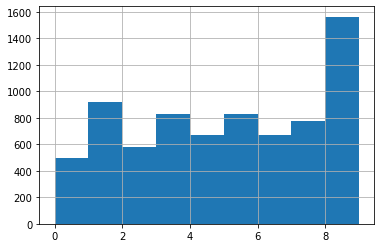

In [7]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [8]:
balanced_train_df.shape


(11000, 7)

# Decode all the RLEs into Images
We make a generator to produce batches of images

In [9]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

# Make the Validation Set¶


In [10]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


# Augment Data


In [11]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

Using TensorFlow backend.
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/

In [12]:
gc.collect()

22

# Build ResNet34+ Unet Model¶
Here we use a slight deviation on the U-Net standard

In [13]:
import numpy as np
import pandas as pd
import six

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize


from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.regularizers import l2

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

Create Upsample layer¶

In [14]:
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Concatenate

def handle_block_names_decode(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name


def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names_decode(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'1')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer


def Transpose2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names_decode(stage)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name)(input_tensor)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer

# Define Unet model (Decoder)¶


In [15]:
def build_unet(backbone, classes, last_block_filters, skip_layers,
               n_upsample_blocks=5, upsample_rates=(2,2,2,2,2),
               block_type='upsampling', activation='sigmoid',
               **kwargs):

    input = backbone.input
    x = backbone.output
    print(x)
    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    # convert layer names to indices
    skip_layers = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                    for l in skip_layers])
    for i in range(n_upsample_blocks):

        # check if there is a skip connection
        if i < len(skip_layers):
            print(backbone.layers[skip_layers[i]])
            print(backbone.layers[skip_layers[i]].output)
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsample_rates[i], upsample_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks-(i+1))

        x = up_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)

    if classes < 2:
        activation = 'sigmoid'

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)

    return model

# Built ResNet34 model¶
Reference this github

In [16]:
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Add
from keras.layers import ZeroPadding2D

def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def basic_identity_block(filters, stage, block):

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer


def basic_conv_block(filters, stage, block, strides=(2, 2)):

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def conv_block(filters, stage, block, strides=(2, 2)):
    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        shortcut = Conv2D(filters*4, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer


def identity_block(filters, stage, block):

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

In [17]:
def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params


def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params


In [18]:
import keras.backend as K
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Dense
from keras.models import Model
from keras.engine import get_source_inputs

import keras
from distutils.version import StrictVersion

if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
    from keras.applications.imagenet_utils import _obtain_input_shape
else:
    from keras_applications.imagenet_utils import _obtain_input_shape
    
def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format='channels_last',
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model

# Load pretrain Weight by using ImageNet trained¶
Reference this GITHUB

In [19]:
from keras.utils import get_file


def find_weights(weights_collection, model_name, dataset, include_top):
    w = list(filter(lambda x: x['model'] == model_name, weights_collection))
    w = list(filter(lambda x: x['dataset'] == dataset, w))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w


def load_model_weights(weights_collection, model, dataset, classes, include_top):
    weights = find_weights(weights_collection, model.name, dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))

In [20]:
weights_collection = [

    # ResNet34
    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': True,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000.h5',
        'name': 'resnet34_imagenet_1000.h5',
        'md5': '2ac8277412f65e5d047f255bcbd10383',
    },

    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
    }]

# Buil Unet model base on ResNet34¶


In [21]:
#Freeze Encoder weight if needed

def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return

In [22]:
def UResNet34(input_shape=(None, None, 3), classes=1, decoder_filters=16, decoder_block_type='upsampling',
                       encoder_weights=None, input_tensor=None, activation='sigmoid', **kwargs):

    backbone = build_resnet(input_tensor=None,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=False,
                         block_type='basic')
    backbone.name = 'resnet34'
    
    if encoder_weights == True:
        load_model_weights(weights_collection, backbone , dataset= 'imagenet', classes = 1, include_top=False)
    
    skip_connections = list([129, 74, 37, 5]) # for resnet 34
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, block_type=decoder_block_type,
                       activation=activation, **kwargs)
    model.name = 'u-resnet34'
    
    #freeze_model(backbone)

    return model

In [23]:
seg_model = UResNet34(input_shape=(768,768,3),encoder_weights=True)

Tensor("relu1/Relu:0", shape=(None, 24, 24, 512), dtype=float32)
Tensor("stage4_unit1_relu1/Relu:0", shape=(None, 48, 48, 256), dtype=float32)
Tensor("stage3_unit1_relu1/Relu:0", shape=(None, 96, 96, 128), dtype=float32)
Tensor("stage2_unit1_relu1/Relu:0", shape=(None, 192, 192, 64), dtype=float32)
Tensor("relu0/Relu:0", shape=(None, 384, 384, 64), dtype=float32)


In [24]:
seg_model.summary()


Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 768, 768, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 774, 774, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 384, 384, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________________

# Define Loss function


In [25]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [26]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
#seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [27]:
gc.collect()

387

# Set Training Check Point¶


In [28]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/jake/venv/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


# Comiple model¶


In [29]:
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=bce_logdice_loss, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [30]:
"""
weight_path="{}_weights.best.hdf5".format('seg_model')

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(weight_path, save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)
"""

'\nweight_path="{}_weights.best.hdf5".format(\'seg_model\')\n\nearly_stopping = EarlyStopping(patience=10, verbose=1)\nmodel_checkpoint = ModelCheckpoint(weight_path, save_best_only=True, verbose=1)\nreduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)\n'

# Start Training¶


In [31]:
epochs = 100
batch_size = 32

step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model.fit_generator(aug_gen,
                            steps_per_epoch=step_count,
                            validation_data=(valid_x, valid_y), 
                            epochs=5,
                            callbacks=callbacks_list,shuffle=True)]

Epoch 1/5
200/200 [==============================] - 134s 672ms/step - loss: 2.8225 - dice_coef: 0.1183 - binary_accuracy: 0.9463 - true_positive_rate: 0.5485 - val_loss: 5.3100 - val_dice_coef: 0.1204 - val_binary_accuracy: 0.9993 - val_true_positive_rate: nan

Epoch 00001: val_dice_coef improved from -inf to 0.12039, saving model to seg_model_weights.best.hdf5
Epoch 2/5
200/200 [==============================] - 113s 565ms/step - loss: 1.5819 - dice_coef: 0.2133 - binary_accuracy: 0.9934 - true_positive_rate: 0.5189 - val_loss: 5.8631 - val_dice_coef: 0.0440 - val_binary_accuracy: 0.9993 - val_true_positive_rate: nan

Epoch 00002: val_dice_coef did not improve from 0.12039
Epoch 3/5
200/200 [==============================] - 112s 560ms/step - loss: 1.3618 - dice_coef: 0.2569 - binary_accuracy: 0.9949 - true_positive_rate: nan - val_loss: 5.8811 - val_dice_coef: 0.0610 - val_binary_accuracy: 0.9993 - val_true_positive_rate: nan

Epoch 00003: val_dice_coef did not improve from 0.12039


In [32]:
gc.collect()


192

In [33]:
seg_model.load_weights(weight_path)
seg_model.save(path + '/models/seg_model_unet34.h5')

# Plot loss history¶


Text(0.5, 1.0, 'DICE')

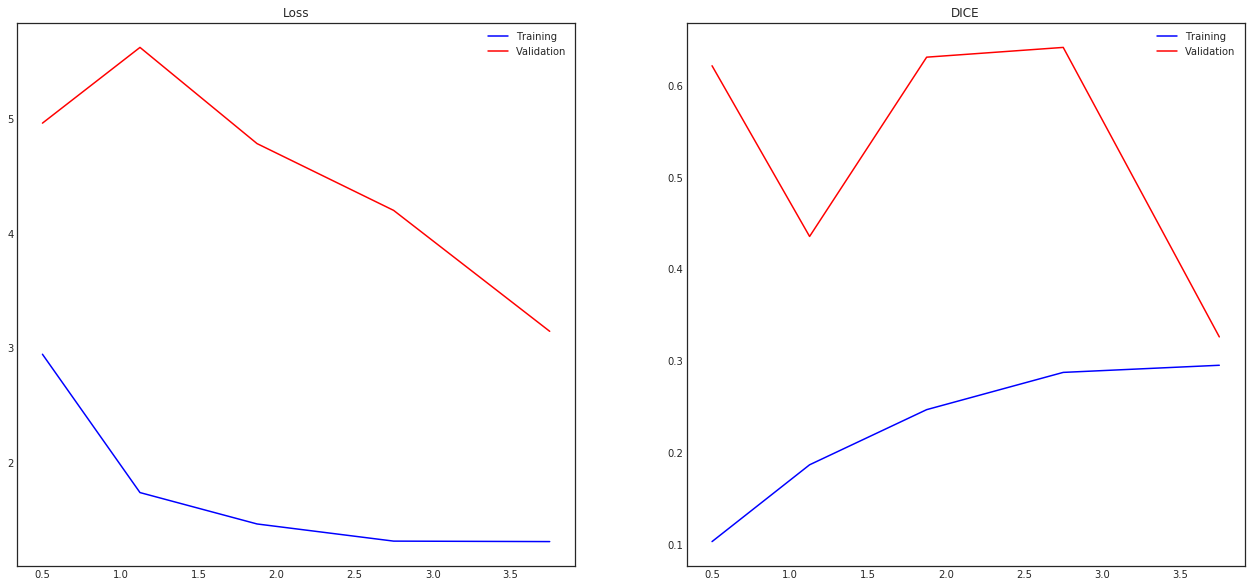

In [35]:
epich = np.cumsum(np.concatenate(
    [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate(
        [mh.history['val_loss'] for mh in loss_history]), 'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate(
    [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                 epich, np.concatenate(
        [mh.history['val_dice_coef'] for mh in loss_history]),
                 'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('DICE')

# Prepare Full Resolution Model¶
Here we account for the scaling so everything can happen in the model itself

In [36]:
IMG_SCALING

(1, 1)

In [38]:
from keras import models, layers
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save(path+ '/models/fullres_model_unet34.h5')

In [39]:
fullres_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_1 (Average (None, None, None, 3)     0         
_________________________________________________________________
u-resnet34 (Model)           multiple                  24453178  
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, None, None, 1)     0         
Total params: 24,453,178
Trainable params: 24,437,812
Non-trainable params: 15,366
_________________________________________________________________


# Run the test data¶


In [40]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

15606 test images found


InvalidArgumentError:  Size 1 must be non-negative, not -21
	 [[{{node u-resnet34/bn_data/batchnorm/mul-1-ReshapeNHWCToNCHW-LayoutOptimizer}}]] [Op:__inference_keras_scratch_graph_57257]

Function call stack:
keras_scratch_graph


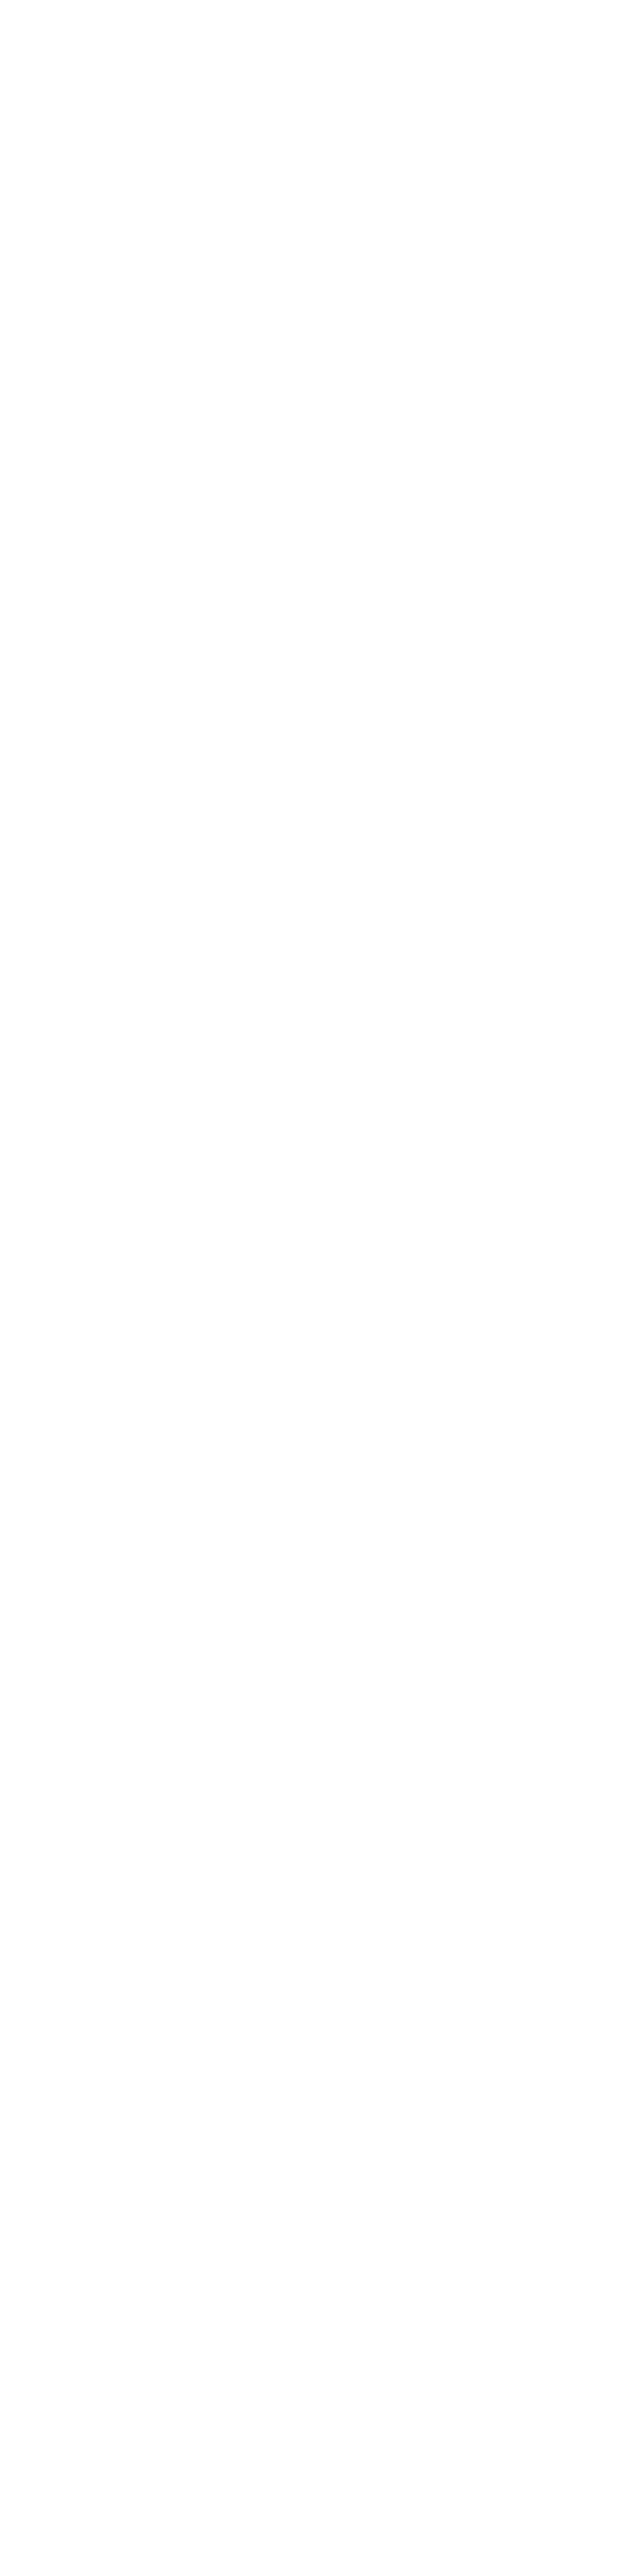

In [41]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('./pic/validation.png')

# Submission¶
We merge part1 trainsfer learning for detect ship exist result to generate submit result
Please refer the submission result kernel : https://www.kaggle.com/super13579/unet34-predict-result